# <span style="color:blue">Transfer Learning in PyTorch</span>

This is a tutorial on model creation and transfer learning in [PyTorch](https://pytorch.org/). There are many ways to create/modify a model in PyTorch and we are not going over an exhaustive list. The goal here is to do this task using minimalistic, understandable, and flexible methods. There will be some preprocessing and data loading that is requred for any training but preprocessing is not the focus of this tutorial, hence we go over it very briefly without explanations. Also, we assume the reader is familiar with the basics of the theory of convolutional neural networks. The tutorial sections are:

[1. Pre-requisites](#Pre-requisites)

[2. Basics of Model Creation](#basics)

[3. Finetuning Pretrained Models and Transfer Learning](#transfer)

<a id='Pre-requisites'></a>

# <span style="color:blue">1. Pre-requisites</span>

To continue with the tutorial you will need to import some standard and third party libraries. We recommend that you use [Anaconda](https://www.anaconda.com/download/) for easier package management. Follow this [link](https://conda.io/docs/user-guide/tasks/manage-environments.html#creating-an-environment-with-commands) to create an enviroment and then activate the enviroment. The libraries `numpy`, `jupyter notebook`, and `matplotlib`can be install using `pip`:
```
pip install library_name
```
Look at this [link](https://anaconda.org/anaconda/pillow) to install `pillow`. Finally look at the official [PyTorch](https://pytorch.org/) page for appropriate installation for your OS.

If you have a GPU with [CUDA](https://developer.nvidia.com/cuda-downloads) capabilities, it can speed up your computations but it is not necessary.

In [1]:
# standard
import os
from itertools import chain

# third party
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [2]:
# Globally set PyTorch device: cuda if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

#### Preprocessing

Here we download and preprocess the [STL10](https://cs.stanford.edu/~acoates/stl10/) as our dataset. The size of this dataset is small which makes it more appealing for transfer learning tasks which is a part of this tutorial. Parts of the code is borrowed from the official PyTorch examples at [PyTorch](https://pytorch.org/). Since, preprocessing is not the focus of the tutorial we go over this part quickly. 

In [3]:
# define a transformation to convert data to tensors, normalize it, and resize it
batch_size = 4
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
resize = transforms.Resize((224,224), interpolation=2)
transform_compose = transforms.Compose([resize,to_tensor,normalize])

# data folder
download_folder = r'C:\Users\kushal\Desktop\ML\stl10_binary'

# get the data 
trainset = torchvision.datasets.STL10(root = download_folder, split='train',
                                      transform = transform_compose, download=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.STL10(root = download_folder, split='test',
                                      transform = transform_compose, download=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=True)

#labels
classes = np.array(['plane','bird','car', 'cat','deer',
                    'dog', 'horse', 'monkey', 'ship', 'truck'])

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(trainset)

5000

In [5]:
# visualize the images
def plots_ims(ims, cols=5, titles=None):
    rows = len(ims)//cols if len(ims) % cols == 0 else len(ims)//cols + 1
    f = plt.figure(figsize=(18, 3*rows))
    ims_np = ims.transpose(1,3).transpose(1,2).numpy()
    ims_np_unnormal = np.array([(im-im.min())/(im-im.min()).max() for im in ims_np])
    for i in range(len(ims_np_unnormal)):
        subplot = f.add_subplot(rows, cols, i+1)
        plt.imshow(ims_np_unnormal[i],cmap='gray')
        subplot.axis('Off')
        if titles is not None:
            subplot.set_title(titles[i], fontsize=10)
    plt.show()

images batch shape and type: torch.Size([4, 3, 224, 224]) torch.FloatTensor


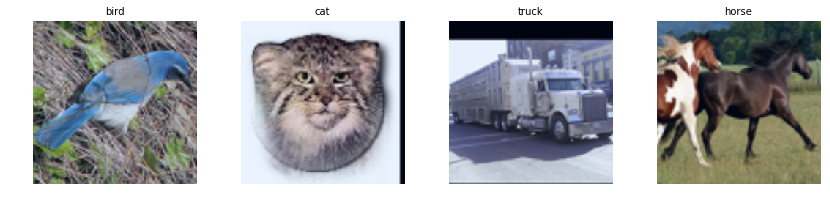

In [9]:
# visualize some samples from the data loader
ims, labels = next(iter(trainloader))
print('images batch shape and type:',ims.size(), ims.type())
plots_ims(ims, titles=classes[labels.numpy()])

<a id='basics'></a>

# <span style="color:blue">2. Basics of Model Creation</span>

PyTorch gives you a lot of flexibility in model creation/customization which is powerful but could be confusing. In the following, we will go over a simple example to clarify model creation in PyTorch. Operations in PyTorch is usually done in several ways:

*Sequential Operations*. In PyTorch you can wrap several operations inside a [sequential](https://pytorch.org/docs/master/nn.html) block. This will automatically run them in order. Using sequential blocks is the easiest way to create your model. Each block can be as simple as one tensor operation or as complex as a full network.

*Functional Operations*. PyTorch [functional](https://pytorch.org/docs/master/_modules/torch/nn/functional.html) operations allow us to apply specific operation to previously defined tensors. Functional operations are usually stateless.

*Computational Graph*. After defining our parameters (or group of parameters wrapped in a sequential module), we specify how the info is passed between our sequential/functional operations. This creates our [computational graph](http://colah.github.io/posts/2015-08-Backprop/). This step is usually implemented in the `forward()` method of the model.

In general, there are two common ways to create our model in PyTorch:

- **Sequential model**. Create the parameteres in the `__init__` of the model and wrap them together with the corresponding operations in a sequential block to specify the flow of the info in the computational graph.

- **Functional model**. Create the parameteres in the `__init__` of the model. Then in the `forward()` method specify how to use the parameters and functional operations to transform the tensors and pass them between the operations. 

The sequential models are easier to work with and they are adequate for most of the common tasks. However, the sequential-functional combination gives us more flexibility in creating unconventional models and this is one of the great features of PyTorch. We will focus on Sequential model creation here.

#### Sequential Model Creation

The most common way to create a convolutional neural network (CNN) in PyTorch is to define the convolutional parameters of the model in a sequential block and define the dense layers in another sequential block. Then stitch them together according to the structure of the model in the `forward()` method. This forms the computational graph. In the following we define a model with 3 convolutional layers and 2 fully connected layers. Remember that you need to reshape the output of the convolutional layers before fed it to the dense layers. We do this using the `view()` function.

In [10]:
class Net_Seq(nn.Module):
    def __init__(self):
        super(Net_Seq, self).__init__()
        # conv layers wrapped in a sequential block
        self.convs = nn.Sequential(
            # a 2d conv layer with num_channels, out_channels, kernel_size
            nn.Conv2d(3, 16, 3),
            # a ReLU activation function
            nn.ReLU(inplace=True),
            # maxpooling layer with given kernel_size
            nn.MaxPool2d(2),
            # here are the second and third conv layers
            nn.Conv2d(16, 32, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        # dense layers wrapped in a sequential block
        self.dense = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 * 26 * 26, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 10))
    
    # flow of the info in the computional graph
    def forward(self, x):
        # pass the input to the conv layers       
        x = self.convs(x)
        # flatten the incoming activities for the dense layer
        x = x.view(-1, 64 * 26 * 26)
        # pass the data to the dense layers
        x = self.dense(x)
        return x

In [11]:
# create a new instance of our model
net = Net_Seq()
# mount the model to GPU (if available)
net = net.to(device)

You can print the model in order to make sure the parameters are set up correctly. Note that printing the model does not provide you with the structure of the model and just list the parameters. At the time of writing this tutorial, PyTorch does not have an official computational graph visualizer.

In [12]:
net

Net_Seq(
  (convs): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=43264, out_features=128, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

#### Examining the Model

Unlike TensorFlow, PyTorch does not compile the model. Being dyanmic is one of the advantages of PyTorch. But it means we have to be careful about model executation. It is a good idea to pass an input to the model to see if we get the expected output and the data flow in the network is correctly done.

In [13]:
# create a random tensor and mount it to the device
x = torch.empty(1,3,224,224).to(device)
# pass the tensor to the network and examine the output
out = net.forward(x).data
print('The size of the output is ', out.size())
print('The type of the output is ', out.type())

The size of the output is  torch.Size([1, 10])
The type of the output is  torch.FloatTensor


Is this compatible with what you expected?

#### Loss and Optimizer

After defining the network, we need to define the loss function. Depending on the task in hand, one needs to pick/define the appropriate loss. The cross-entropy loss is the standard loss for classification tasks. One can refer to [PyTorch loss page](https://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html) to find other losses. Note that you can define your own loss too.

For the optimizer, we choose [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) which is one of the standard choices for classification tasks. PyTorch has many options for optimization including the standard SGD and others which can be found [here](https://pytorch.org/docs/master/optim.html).

In [14]:
# cross entropy loss for classification
loss = nn.CrossEntropyLoss()

# our choice of optimizer with the specified learning rate
optimizer = optim.Adam(net.parameters(), lr=0.001)

#### Training

Finally, we need to train our model. In our `train` method, we use the previously created `trainloader` to load new training examples. We mount the image data and the labels to the GPU (if available) to boost the calculations.  

Then we feed the image data to the model to get the outputs using the forward method. After that We calculate the loss based on the discrepancy of the output with the true class-ids. We calculate the current loss and we send the error back to the network ([backpropagation](https://en.wikipedia.org/wiki/Backpropagation)) using the optimizer. The rest of the code is to calculate and show the progress information.

In the validation phase, we also calculate the number of correct answers. For calculating the predicted label we use the class with maximum probability assigned by the model.

Notes:
- We need to set the default gradient values to zero. This is because back-propagation in PyTorch is *accumulative* instead of *replaced* which is useful in cases like Recurrent Neural Networks. Here, we are not using an accumulative gradient so we set it to zero on each iteration.
- We use dropouts in the forward pass as a regularizer but in the evaluation phase, we do not need dropout. Such matters can be addressed by setting the model to `train()` or `eval()` mode.

In [15]:
def train(model, optimizer, loss, num_epochs=4):
    for epoch in range(num_epochs):
        # set the model to training mode
        model.train()
        loss_sum = 0.0
        # loop over the data batches
        for i, data in enumerate(trainloader, 0):#trainloader 
            inputs, class_ids = data
            # mount the data to gpu (if availabe)
            inputs, class_ids = inputs.to(device), class_ids.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            # loss
            temp_loss = loss(outputs, class_ids)
            # backprop
            temp_loss.backward()
            optimizer.step()
            # print statistics
            loss_sum += temp_loss.item()
            if i % 200 == 199:
                print('| epoch: %d | %3d*%5d images | loss = %.3f' %
                      (epoch + 1, batch_size , i + 1, loss_sum / 200))
                loss_sum = 0.0
        
        # test the model accuracy on the validation data
        model.eval()
        val_loss = 0
        correct = 0
        for i, data in enumerate(testloader, 0):
            inputs, class_ids = data
            inputs, class_ids = inputs.to(device), class_ids.to(device)
            # no need to calculate gradients in validation phase
            with torch.no_grad():
                outputs = model(inputs)
                temp_loss = loss(outputs, class_ids)
                val_loss += temp_loss.item()
                # get the index of the max log-probability
                preds = outputs.max(1, keepdim=True)[1]
                # get the ratio of correct predictions
                correct += preds.eq(class_ids.view_as(preds)).long().cpu().sum()
        # average of the loss
        val_loss /= i
        # print info
        print('\n | Test loss = {:.3f} | Test accuracy = {:.0f}% \n'.format(
            val_loss, 100. * correct / len(testloader.dataset)
        ))

In [19]:
train(net,optimizer,loss)

| epoch: 1 |   4*  200 images | loss = 2.286
| epoch: 1 |   4*  400 images | loss = 2.094
| epoch: 1 |   4*  600 images | loss = 1.956
| epoch: 1 |   4*  800 images | loss = 1.831
| epoch: 1 |   4* 1000 images | loss = 1.767
| epoch: 1 |   4* 1200 images | loss = 1.766

 | Test loss = 1.612 | Test accuracy = 39% 

| epoch: 2 |   4*  200 images | loss = 1.670
| epoch: 2 |   4*  400 images | loss = 1.661
| epoch: 2 |   4*  600 images | loss = 1.622
| epoch: 2 |   4*  800 images | loss = 1.626
| epoch: 2 |   4* 1000 images | loss = 1.573
| epoch: 2 |   4* 1200 images | loss = 1.617

 | Test loss = 1.555 | Test accuracy = 42% 

| epoch: 3 |   4*  200 images | loss = 1.511
| epoch: 3 |   4*  400 images | loss = 1.526
| epoch: 3 |   4*  600 images | loss = 1.487
| epoch: 3 |   4*  800 images | loss = 1.449
| epoch: 3 |   4* 1000 images | loss = 1.463
| epoch: 3 |   4* 1200 images | loss = 1.430

 | Test loss = 1.411 | Test accuracy = 46% 

| epoch: 4 |   4*  200 images | loss = 1.372
| epoch

We get around 45% accuracy with our model. This is not bad cosidering 10% chance of random answers being correct and the fact that the data set is small. One can get better results by implementing better network architecture or data augmentation. But that is the subject of another tutorial. Here, we will use a more effective method which is *transfer learning*.

<a id='transfer'></a>

# <span style="color:blue">3. Finetuning Pretrained Models and Transfer Learning</span>

In this section, we leverage the filters learnt in a standard deep architecture trained on a large data set such as ImageNet to get better results in our small data set. This strategy is called **transfer learning** and it is one of the most effective approaches in solving deep learning problems. Here we use a VGG16 network. Other architectures can be used very similarly. One can find more models from [here](https://github.com/pytorch/vision/tree/master/torchvision/models). 

Firstly, we download the weights of the pretrained model and store them in the `pretrained_model`. Then by calling the `children()` method (or `named_children()`), we can access the weights. In this case, model is separated into two sequential blocks: convolutional block and fully connected (classifier) block. Note that one can call `new_instance = torchvision.models.model_name(pretrained=True)` to create a new instance of the pretrained model and by calling/printing the instance, you can see the parameters of the model.

Here, we use only the convolutional block of the pretrained model. Using `nn.Sequential()` we can wrap these parameters to a new block in our own network. Then we add our own fully connected layers that we will train (finetune) later. Note that the number of the nodes in the first fully connected layer should be consistent with the incoming flatten activities from the last convolutional layer. This structure of the network to have two blocks of convolutional and dense is the most common structure for finetuning CNNs in PyTorch. However, we find the equivalent structure in the next seciton that is fully sequential and easier to work with.

In [16]:
class TransferNet(nn.Module):
    def __init__(self):
        super(TransferNet, self).__init__()
        
        # load the pretrained model
        pretrained_model = torchvision.models.vgg16(pretrained=True)
        # store the convolutional layers of the pretrained model
        self.pretrained_layers = pretrained_model.features
        
        # add the new dense layers
        self.dense = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 7 * 7, 4000),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4000, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, 10))
    
    # flow of the info in the computional graph
    def forward(self, x):
        # pass the input to the pretrained convolutional layers       
        x = self.pretrained_layers(x)
        # flatten the incoming activities
        x = x.view(-1, 512 * 7 * 7)
        # pass the data to the dense layers
        x = self.dense(x)
        return x

In [17]:
# create a new instance of the model
fineTune = TransferNet()
# mount the model to the GPU
fineTune = fineTune.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\kushal/.torch\models\vgg16-397923af.pth
100.0%


In [18]:
fineTune

TransferNet(
  (pretrained_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

Now we finetune the model. The layers borrowed from pretrained VGG are already trained on ImageNet data set and we want to keep them as they are. Hence we only pass the newly added dense layers for training. The rest of the setup is similar to what we had before.

Note that another way to specify what parts of the model to train is to set `param.requires_grad = False` for the parts of the network that are not being trained. And then train the whole network. This will allow you to *freeze* or *unfreeze* different parts of the network whenever you want.

In [19]:
# pass the parameters that need to be optimized to the optimizer
params = chain(fineTune.dense.parameters())
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(params, lr=0.001)

In [ ]:
train(fineTune,optimizer,loss,num_epochs=2)

| epoch: 1 |   4*  200 images | loss = 1.664
| epoch: 1 |   4*  400 images | loss = 0.977
| epoch: 1 |   4*  600 images | loss = 0.849
| epoch: 1 |   4*  800 images | loss = 0.801
| epoch: 1 |   4* 1000 images | loss = 0.817
| epoch: 1 |   4* 1200 images | loss = 1.036

 | Test loss = 0.501 | Test accuracy = 86% 

| epoch: 2 |   4*  200 images | loss = 0.798
| epoch: 2 |   4*  400 images | loss = 0.614
| epoch: 2 |   4*  600 images | loss = 0.587


We get to 90% accuracy which is pretty impressive considering the small training size and the complexity of the data. This high accuracy is partly because STL10 dataset is very similar to ImageNet but much smaller so our pretrained block was already exposed to many more similar examples. This claifies the power of finetuning if applied to the right problem.

Why is test loss smaller than training loss?

Next, we visualize some examples of the model predictions.

In [ ]:
# get the batch and mount it to the GPU (if available) 
inputs, labels = next(iter(testloader))
inputs, labels = inputs.to(device), labels.to(device)
# predict the classes
outputs = fineTune(inputs)
preds = outputs.max(1, keepdim=True)[1]
pred_classes = classes[preds.cpu().numpy().flatten()]
# visualize the predictions
plots_ims(inputs.cpu(), titles=pred_classes)